In [ ]:
## import all libraries

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from IPython.display import clear_output
import random
import torchvision

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
set_random_seed(3407)

In [ ]:
## download train and test dataset with normalize
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128 # size of one batch for train


train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('../data', train=True, download=True, transform=transform),
        batch_size=batch_size, shuffle=True)


test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('../data', train=False, transform=transform),
        batch_size=batch_size, shuffle=True)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


In [ ]:
# densenet121
model = torchvision.models.densenet121(pretrained=True)
model = model.to(device)

# create Adam optimization
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# create loss func
criterion = nn.CrossEntropyLoss()

In [ ]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.grid()
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

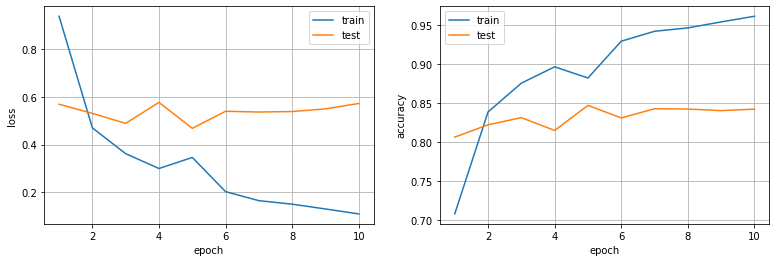

Best test accuracy: 0.8474


In [ ]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}'):
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()

    train_losses += [running_loss / len(train_loader.dataset)]
    train_accuracies += [running_accuracy / len(train_loader.dataset)]


    running_loss, running_accuracy = 0.0, 0.0
    for images, labels in tqdm(test_loader, desc=f'Testing {epoch}/{num_epochs}'):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(images)
            loss = criterion(logits, labels)

        running_loss += loss.item() * images.shape[0]
        running_accuracy += (logits.argmax(dim=-1) == labels).sum().item()

    test_losses += [running_loss / len(test_loader.dataset)]
    test_accuracies += [running_accuracy / len(test_loader.dataset)]
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

print(f'Best test accuracy: {max(test_accuracies)}')            

In [ ]:
print(f'Top-1 error: {(1 - test_accuracies[-1]):4.3f}')

Top-1 error: 0.157


I think we don't need to top5 error, because we have only 10 classes. Also our error now is about 0.16, as I know, best models have 0.08 error on CIFAR10, but I don't think it's necessary

Next, we can look at some predictions of the model to get more familiar with the dataset. Let's print some images with real class and our predict

In [ ]:
copy_train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('../data', train=True, download=True, transform=transform),
        batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Class: frog
Predict: frog


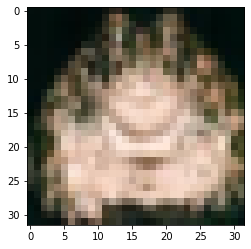

Class: deer
Predict: deer


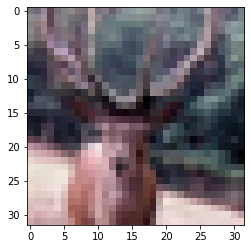

Class: ship
Predict: ship


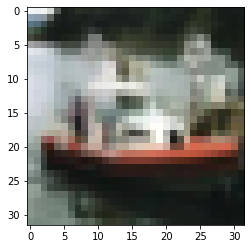

Class: truck
Predict: truck


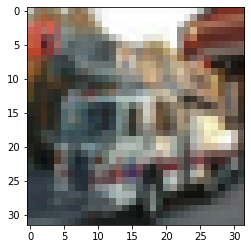

Class: frog
Predict: frog


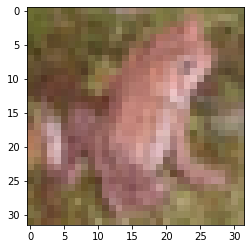

In [ ]:
exmp_batch, label_batch = next(iter(copy_train_loader))
with torch.no_grad():
    logits = model(exmp_batch.to(device))
    preds = logits.argmax(dim=-1)

for i in range(1, 42, 10):
    print('Class:', classes[label_batch[i].item()])
    print('Predict:', classes[preds[i].item()])
    imshow(torchvision.utils.make_grid(exmp_batch[i]))

Time to FSGM attack!

In [ ]:
def fast_gradient_sign_method(model, imgs, labels, epsilon=0.02):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    # Calculate loss by NLL
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

In [ ]:
adv_imgs, noise_grad = fast_gradient_sign_method(model, exmp_batch, label_batch, epsilon=0.02)
with torch.no_grad():
    adv_preds = model(adv_imgs.to(device))
    new_preds = adv_preds.argmax(dim=-1)

Image


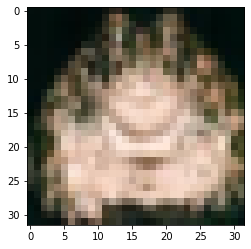

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarial


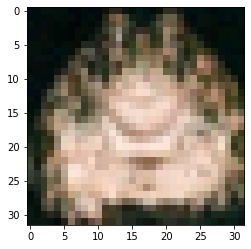

Noise


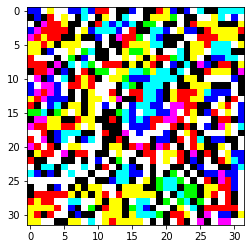

Real class: frog
Old predict: frog
New predict: frog
Image


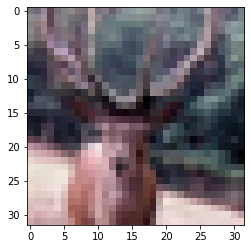

Adversarial


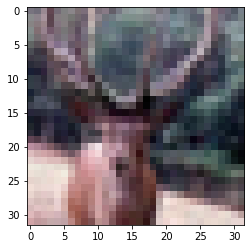

Noise


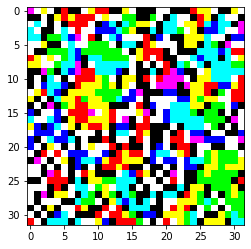

Real class: deer
Old predict: deer
New predict: deer
Image


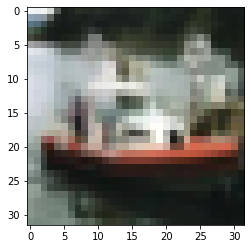

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarial


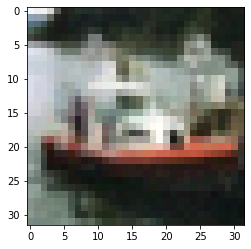

Noise


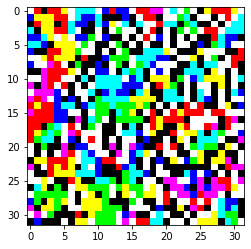

Real class: ship
Old predict: ship
New predict: ship
Image


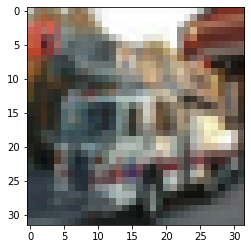

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarial


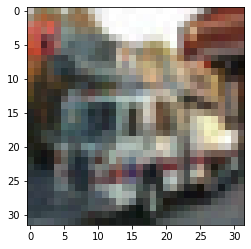

Noise


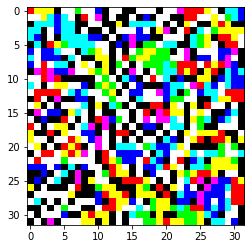

Real class: truck
Old predict: truck
New predict: truck
Image


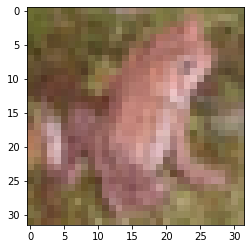

Adversarial


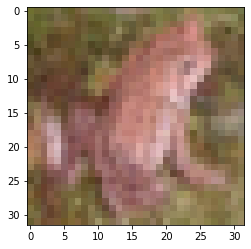

Noise


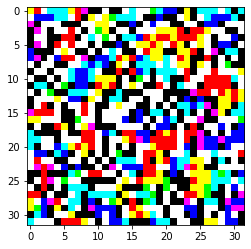

Real class: frog
Old predict: frog
New predict: frog


In [ ]:
for i in range(1, 42, 10):
    print('Image')
    imshow(torchvision.utils.make_grid(exmp_batch[i]))

    print('Adversarial')
    imshow(torchvision.utils.make_grid(adv_imgs[i]))

    print('Noise')
    imshow(torchvision.utils.make_grid(noise_grad[i]))

    print('Real class:', classes[label_batch[i].item()])
    print('Old predict:', classes[preds[i].item()])
    print('New predict:', classes[new_preds[i].item()])

Image


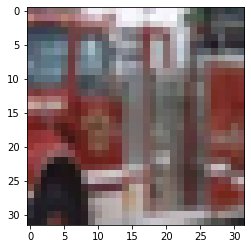

Adversarial


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


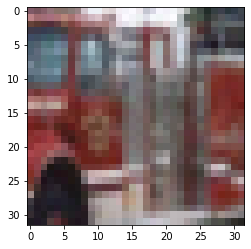

Noise


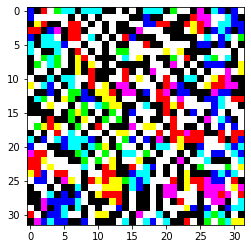

Real class: truck
Old predict: truck
New predict: cat
Image


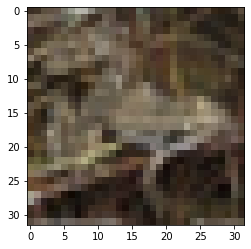

Adversarial


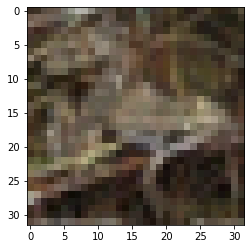

Noise


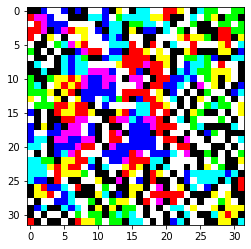

Real class: frog
Old predict: frog
New predict: bird
Image


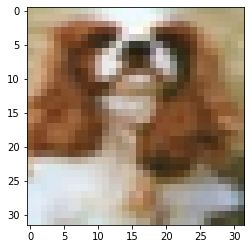

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarial


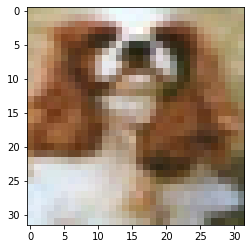

Noise


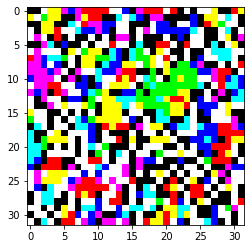

Real class: dog
Old predict: dog
New predict: cat


In [ ]:
wrong = 0
for i in range(batch_size):
    if (new_preds[i].item() != preds[i].item()):
        print('Image')
        imshow(torchvision.utils.make_grid(exmp_batch[i]))

        print('Adversarial')
        imshow(torchvision.utils.make_grid(adv_imgs[i]))

        print('Noise')
        imshow(torchvision.utils.make_grid(noise_grad[i]))

        print('Real class:', classes[label_batch[i].item()])
        print('Old predict:', classes[preds[i].item()])
        print('New predict:', classes[new_preds[i].item()])
        wrong += 1
        if (wrong >= 3):
            break

In [ ]:
err_on_batch = 0
for i in range(batch_size):
    if (new_preds[i].item() != preds[i].item()):
        err_on_batch += 1
print('error on batch =', err_on_batch / batch_size)

error on batch = 0.3046875


In [ ]:
test_accuracies_adv = []
running_accuracy = 0.0
for images, labels in tqdm(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    adv_imgs, noise_grad = fast_gradient_sign_method(model, images, labels, epsilon=0.02)

    with torch.no_grad():
        adv_preds = model(adv_imgs.to(device))

    running_accuracy += (adv_preds.argmax(dim=-1) == labels).sum().item()

test_accuracies_adv += [running_accuracy / len(test_loader.dataset)]
print(f'Top-1 error: {(1 - test_accuracies[-1]):4.3f}')
print(f'Top-1 adv error: {(1 - test_accuracies_adv[0]):4.3f}')

  0%|          | 0/79 [00:00<?, ?it/s]

Top-1 error: 0.157
Top-1 adv error: 0.419


Not bad

Let's try increase epsilon a bit

In [ ]:
adv_imgs, noise_grad = fast_gradient_sign_method(model, exmp_batch, label_batch, epsilon=0.1)
with torch.no_grad():
    adv_preds = model(adv_imgs.to(device))
    new_preds = adv_preds.argmax(dim=-1)

Image


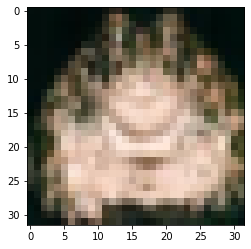

Adversarial


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


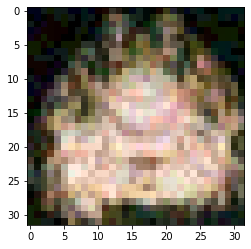

Noise


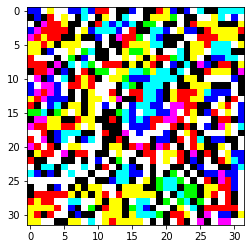

Real class: frog
Old predict: frog
New predict: frog
Image


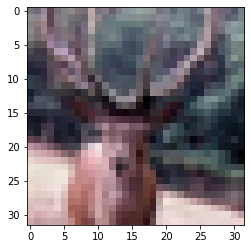

Adversarial


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


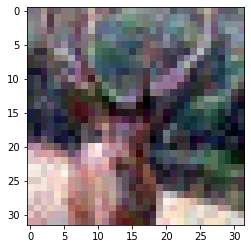

Noise


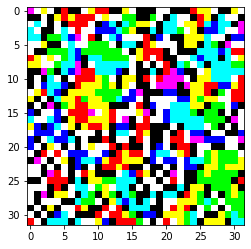

Real class: deer
Old predict: deer
New predict: deer
Image


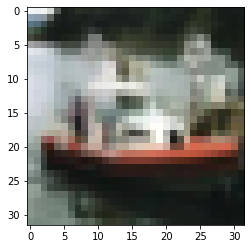

Adversarial


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


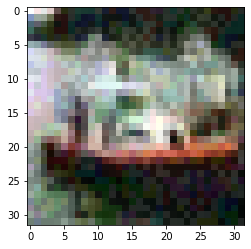

Noise


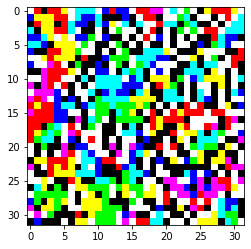

Real class: ship
Old predict: ship
New predict: truck
Image


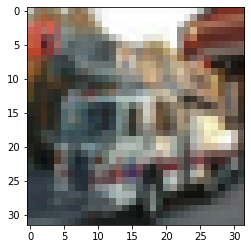

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarial


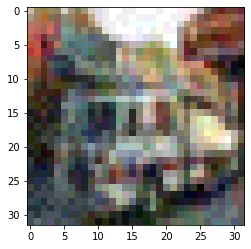

Noise


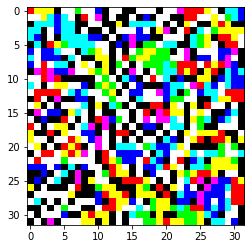

Real class: truck
Old predict: truck
New predict: truck
Image


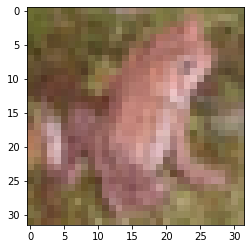

Adversarial


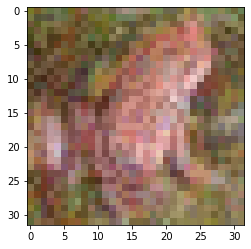

Noise


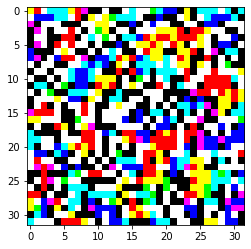

Real class: frog
Old predict: frog
New predict: frog


In [ ]:
for i in range(1, 42, 10):
    print('Image')
    imshow(torchvision.utils.make_grid(exmp_batch[i]))

    print('Adversarial')
    imshow(torchvision.utils.make_grid(adv_imgs[i]))

    print('Noise')
    imshow(torchvision.utils.make_grid(noise_grad[i]))

    print('Real class:', classes[label_batch[i].item()])
    print('Old predict:', classes[preds[i].item()])
    print('New predict:', classes[new_preds[i].item()])

Adversarial Images still looks ok

In [ ]:
test_accuracies_adv = []
running_accuracy = 0.0
for images, labels in tqdm(test_loader):
    images = images.to(device)
    labels = labels.to(device)

    adv_imgs, noise_grad = fast_gradient_sign_method(model, images, labels, epsilon=0.1)

    with torch.no_grad():
        adv_preds = model(adv_imgs.to(device))

    running_accuracy += (adv_preds.argmax(dim=-1) == labels).sum().item()

test_accuracies_adv += [running_accuracy / len(test_loader.dataset)]
print(f'Top-1 error: {(1 - test_accuracies[-1]):4.3f}')
print(f'Top-1 adv error: {(1 - test_accuracies_adv[0]):4.3f}')

  0%|          | 0/79 [00:00<?, ?it/s]

Top-1 error: 0.157
Top-1 adv error: 0.616


Okay, let's plot graph of adversarial error

In [ ]:
epsilons = [0]
epsilons += [x / 100 for x in range(2, 200, 10)]
error_on_eps = []

for epsilon in epsilons:
    test_accuracies_adv = []
    running_accuracy = 0.0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        adv_imgs, noise_grad = fast_gradient_sign_method(model, images, labels, epsilon=epsilon)

        with torch.no_grad():
            adv_preds = model(adv_imgs.to(device))

        running_accuracy += (adv_preds.argmax(dim=-1) == labels).sum().item()

    test_accuracies_adv += [running_accuracy / len(test_loader.dataset)]
    error_on_eps += [1 - test_accuracies_adv[0]]

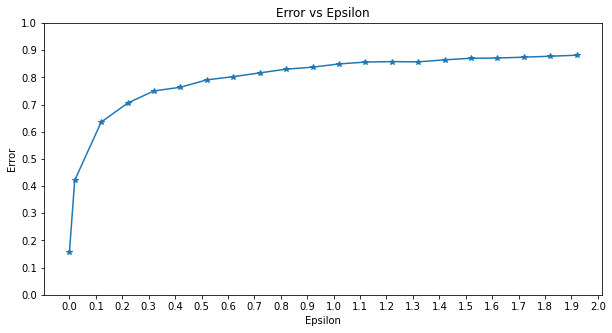

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(epsilons, error_on_eps, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 2.1, step=0.1))
plt.title("Error vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Error")
plt.show()

As we see, with epsilon = 0.6, error = 0.8. After this, error growing slow. Because we have only 10 classes, so even with random predict, error would be about 0.9

Image


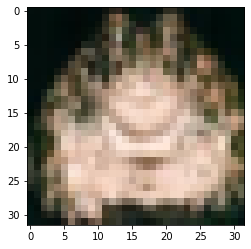

Epsilon: 0
Real class: frog
Old predict: frog
New predict: frog
Adversarial 



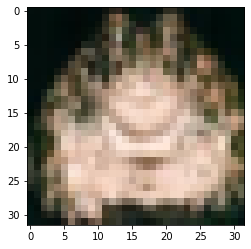

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epsilon: 0.02
Real class: frog
Old predict: frog
New predict: frog
Adversarial 



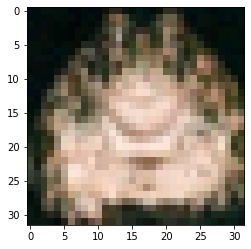

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epsilon: 0.12
Real class: frog
Old predict: frog
New predict: frog
Adversarial 



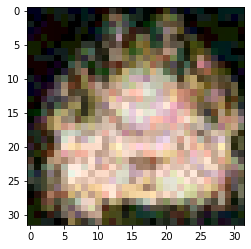

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epsilon: 0.22
Real class: frog
Old predict: frog
New predict: frog
Adversarial 



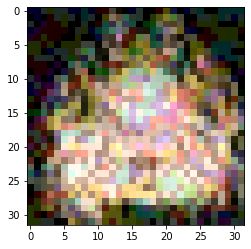

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epsilon: 0.32
Real class: frog
Old predict: frog
New predict: frog
Adversarial 



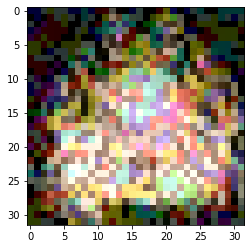

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epsilon: 0.42
Real class: frog
Old predict: frog
New predict: frog
Adversarial 



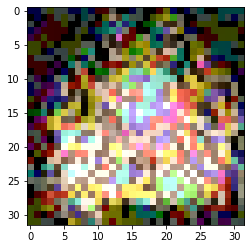

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epsilon: 0.52
Real class: frog
Old predict: frog
New predict: frog
Adversarial 



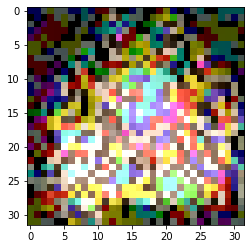

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epsilon: 0.62
Real class: frog
Old predict: frog
New predict: frog
Adversarial 



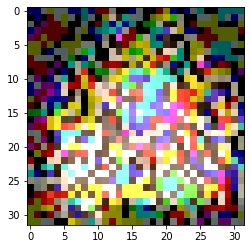

In [ ]:
print('Image')
imshow(torchvision.utils.make_grid(exmp_batch[i]))
    
for epsilon in epsilons[:8]:
    adv_imgs, noise_grad = fast_gradient_sign_method(model, exmp_batch, label_batch, epsilon=epsilon)
    with torch.no_grad():
        adv_preds = model(adv_imgs.to(device))
        new_preds = adv_preds.argmax(dim=-1)

    for i in range(1, 9, 10):
        print('Epsilon:', epsilon)
        print('Real class:', classes[label_batch[i].item()])
        print('Old predict:', classes[preds[i].item()])
        print('New predict:', classes[new_preds[i].item()])

        print('Adversarial', '\n')
        imshow(torchvision.utils.make_grid(adv_imgs[i]))

On epsilon = 0.12 image is still ok, so our adversarial error is about 0.6 - 0.7